In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from pandas import DataFrame
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dropout, Activation, Flatten,TimeDistributed, BatchNormalization, LeakyReLU, Activation 
from keras.models import Model
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]
ZR_46_TR, ZR_46_TE= ZR_46[0:250], ZR_46[250:len(ZR_46)]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]
ZR_N46_TR, ZR_N46_TE= ZR_N46[0:250], ZR_N46[250:len(ZR_N46)]

In [6]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back, look_forward):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    #df = df.drop(0)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [7]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: t+60
look_back=12
look_forward=60

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)
trainX_100, train_y_100 = ZR_100_TR_I.iloc[:, 0:-1], ZR_100_TR_I.iloc[:, -1]

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)
testX_100, test_y_100 = ZR_100_TE_I.iloc[:, 0:-1], ZR_100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_46_TR_I=timeseries_to_supervised_R(ZR_46_TR, look_back, look_forward)
trainX_46, train_y_46 = ZR_46_TR_I.iloc[:, 0:-1], ZR_46_TR_I.iloc[:, -1]

# Testdaten 
ZR_46_TE_I=timeseries_to_supervised_R(ZR_46_TE, look_back, look_forward)
testX_46, test_y_46 = ZR_46_TE_I.iloc[:, 0:-1], ZR_46_TE_I.iloc[:, -1]

In [8]:
# Normalisierten Daten
# Inputgröße 100%
# Trainingsdaten
ZR_N100_TR_I=timeseries_to_supervised_R(ZR_N100_TR, look_back, look_forward)
trainX_100N, train_y_100N = ZR_N100_TR_I.iloc[:, 0:-1], ZR_N100_TR_I.iloc[:, -1]

# Testdaten 
ZR_N100_TE_I=timeseries_to_supervised_R(ZR_N100_TE, look_back, look_forward)
testX_100N, test_y_100N = ZR_N100_TE_I.iloc[:, 0:-1], ZR_N100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_N46_TR_I=timeseries_to_supervised_R(ZR_N46_TR, look_back, look_forward)
trainX_46N, train_y_46N = ZR_N46_TR_I.iloc[:, 0:-1], ZR_N46_TR_I.iloc[:, -1]

# Testdaten 
ZR_N46_TE_I=timeseries_to_supervised_R(ZR_N46_TE, look_back, look_forward)
testX_46N, test_y_46N = ZR_N46_TE_I.iloc[:, 0:-1], ZR_N46_TE_I.iloc[:, -1]

In [33]:
# Replizierbarkeit gewährleisten
np.random.seed(1)

In [34]:
# Modell zusammenbauen
# Dateninput: 100 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_100N, train_y_100N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_100N, test_y_100N))

Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 1s - loss: 0.0679 - val_loss: 0.1061
Epoch 2/200
 - 0s - loss: 0.0513 - val_loss: 0.1232
Epoch 3/200
 - 0s - loss: 0.0507 - val_loss: 0.1008
Epoch 4/200
 - 0s - loss: 0.0509 - val_loss: 0.1096
Epoch 5/200
 - 0s - loss: 0.0512 - val_loss: 0.1087
Epoch 6/200
 - 0s - loss: 0.0508 - val_loss: 0.1039
Epoch 7/200
 - 0s - loss: 0.0507 - val_loss: 0.1084
Epoch 8/200
 - 0s - loss: 0.0507 - val_loss: 0.1073
Epoch 9/200
 - 0s - loss: 0.0507 - val_loss: 0.1059
Epoch 10/200
 - 0s - loss: 0.0507 - val_loss: 0.1120
Epoch 11/200
 - 0s - loss: 0.0506 - val_loss: 0.1017
Epoch 12/200
 - 0s - loss: 0.0508 - val_loss: 0.1115
Epoch 13/200
 - 0s - loss: 0.0506 - val_loss: 0.1085
Epoch 14/200
 - 0s - loss: 0.0507 - val_loss: 0.1099
Epoch 15/200
 - 0s - loss: 0.0505 - val_loss: 0.1067
Epoch 16/200
 - 0s - loss: 0.0504 - val_loss: 0.1037
Epoch 17/200
 - 0s - loss: 0.0504 - val_loss: 0.1046
Epoch 18/200
 - 0s - loss: 0.0502 - val_loss: 0.1109
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0234 - val_loss: 0.0181
Epoch 155/200
 - 0s - loss: 0.0236 - val_loss: 0.0143
Epoch 156/200
 - 0s - loss: 0.0233 - val_loss: 0.0182
Epoch 157/200
 - 0s - loss: 0.0235 - val_loss: 0.0156
Epoch 158/200
 - 0s - loss: 0.0235 - val_loss: 0.0166
Epoch 159/200
 - 0s - loss: 0.0236 - val_loss: 0.0203
Epoch 160/200
 - 0s - loss: 0.0234 - val_loss: 0.0164
Epoch 161/200
 - 0s - loss: 0.0234 - val_loss: 0.0181
Epoch 162/200
 - 0s - loss: 0.0234 - val_loss: 0.0164
Epoch 163/200
 - 0s - loss: 0.0233 - val_loss: 0.0177
Epoch 164/200
 - 0s - loss: 0.0241 - val_loss: 0.0157
Epoch 165/200
 - 0s - loss: 0.0233 - val_loss: 0.0158
Epoch 166/200
 - 0s - loss: 0.0235 - val_loss: 0.0165
Epoch 167/200
 - 0s - loss: 0.0234 - val_loss: 0.0187
Epoch 168/200
 - 0s - loss: 0.0233 - val_loss: 0.0172
Epoch 169/200
 - 0s - loss: 0.0232 - val_loss: 0.0174
Epoch 170/200
 - 0s - loss: 0.0232 - val_loss: 0.0160
Epoch 171/200
 - 0s - loss: 0.0231 - val_loss: 0.0181
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

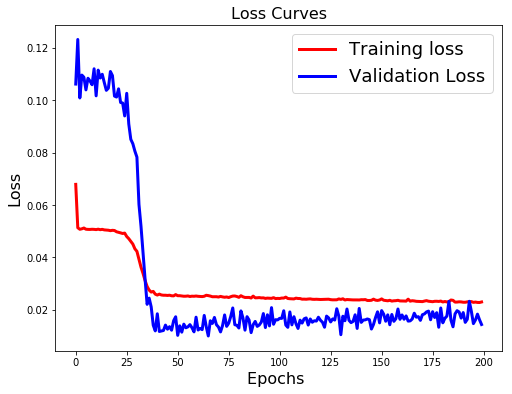

In [35]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [36]:
# Modellperformance bewerten: normalisierte Daten
trainScore = model.evaluate(trainX_100N, train_y_100N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_100N, test_y_100N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.02 MSE (0.15 RMSE)
Test Score: 0.01 MSE (0.12 RMSE)


In [37]:
# Vorhersagen generieren
trainPredict_100N = model.predict(trainX_100N)
testPredict_100N = model.predict(testX_100N)

In [38]:
# Prediction Denormalizing
testPredict_100=scaler.inverse_transform(testPredict_100N)
trainPredict_100=scaler.inverse_transform(trainPredict_100N)

# Evaluation
test_MSE=mean_squared_error(test_y_100,testPredict_100)
train_MSE=mean_squared_error(train_y_100,trainPredict_100)

print(test_MSE,train_MSE)

84769005.38659048 135448549.45207575


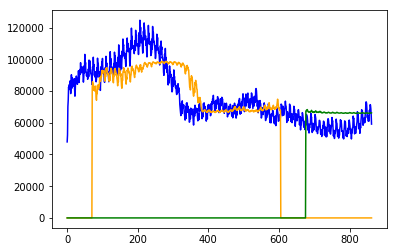

In [39]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_100)+(look_back+look_forward-1)] = trainPredict_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+(2*look_back+2*look_forward-2):len(ZR_100)-(look_back+look_forward-1)+look_back+look_forward] = testPredict_100
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [52]:
# Replizierbarkeit gewährleisten
np.random.seed(2)

In [53]:
# Modell zusammenbauen
# Dateninput: 46 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_46N, train_y_46N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_46N, test_y_46N))

Train on 179 samples, validate on 79 samples
Epoch 1/200
 - 1s - loss: 0.0087 - val_loss: 0.0084
Epoch 2/200
 - 0s - loss: 0.0054 - val_loss: 0.0056
Epoch 3/200
 - 0s - loss: 0.0054 - val_loss: 0.0070
Epoch 4/200
 - 0s - loss: 0.0050 - val_loss: 0.0100
Epoch 5/200
 - 0s - loss: 0.0050 - val_loss: 0.0081
Epoch 6/200
 - 0s - loss: 0.0049 - val_loss: 0.0071
Epoch 7/200
 - 0s - loss: 0.0048 - val_loss: 0.0078
Epoch 8/200
 - 0s - loss: 0.0048 - val_loss: 0.0079
Epoch 9/200
 - 0s - loss: 0.0048 - val_loss: 0.0080
Epoch 10/200
 - 0s - loss: 0.0048 - val_loss: 0.0076
Epoch 11/200
 - 0s - loss: 0.0048 - val_loss: 0.0075
Epoch 12/200
 - 0s - loss: 0.0048 - val_loss: 0.0083
Epoch 13/200
 - 0s - loss: 0.0048 - val_loss: 0.0080
Epoch 14/200
 - 0s - loss: 0.0048 - val_loss: 0.0076
Epoch 15/200
 - 0s - loss: 0.0048 - val_loss: 0.0085
Epoch 16/200
 - 0s - loss: 0.0048 - val_loss: 0.0076
Epoch 17/200
 - 0s - loss: 0.0049 - val_loss: 0.0067
Epoch 18/200
 - 0s - loss: 0.0048 - val_loss: 0.0078
Epoch 19/2

Epoch 154/200
 - 0s - loss: 0.0049 - val_loss: 0.0079
Epoch 155/200
 - 0s - loss: 0.0047 - val_loss: 0.0062
Epoch 156/200
 - 0s - loss: 0.0049 - val_loss: 0.0079
Epoch 157/200
 - 0s - loss: 0.0049 - val_loss: 0.0082
Epoch 158/200
 - 0s - loss: 0.0048 - val_loss: 0.0066
Epoch 159/200
 - 0s - loss: 0.0048 - val_loss: 0.0084
Epoch 160/200
 - 0s - loss: 0.0049 - val_loss: 0.0081
Epoch 161/200
 - 0s - loss: 0.0051 - val_loss: 0.0065
Epoch 162/200
 - 0s - loss: 0.0048 - val_loss: 0.0085
Epoch 163/200
 - 0s - loss: 0.0048 - val_loss: 0.0082
Epoch 164/200
 - 0s - loss: 0.0048 - val_loss: 0.0079
Epoch 165/200
 - 0s - loss: 0.0048 - val_loss: 0.0071
Epoch 166/200
 - 0s - loss: 0.0048 - val_loss: 0.0079
Epoch 167/200
 - 0s - loss: 0.0047 - val_loss: 0.0069
Epoch 168/200
 - 0s - loss: 0.0049 - val_loss: 0.0072
Epoch 169/200
 - 0s - loss: 0.0047 - val_loss: 0.0083
Epoch 170/200
 - 0s - loss: 0.0048 - val_loss: 0.0082
Epoch 171/200
 - 0s - loss: 0.0047 - val_loss: 0.0071
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

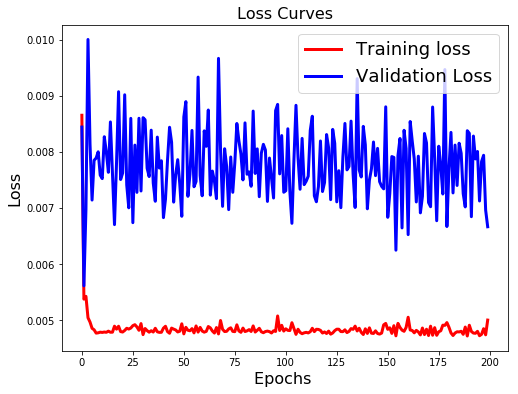

In [54]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [55]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_46N, train_y_46N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_46N, test_y_46N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.07 RMSE)
Test Score: 0.01 MSE (0.08 RMSE)


In [56]:
# Vorhersagen generieren
trainPredict_46N = model.predict(trainX_46N)
testPredict_46N = model.predict(testX_46N)

In [57]:
# Prediction Denormalizing
testPredict_46=scaler.inverse_transform(testPredict_46N)
trainPredict_46=scaler.inverse_transform(trainPredict_46N)

# Evaluation
test_MSE=mean_squared_error(test_y_46,testPredict_46)
train_MSE=mean_squared_error(train_y_46,trainPredict_46)

print(test_MSE,train_MSE)

39213651.78743541 28559578.922655158


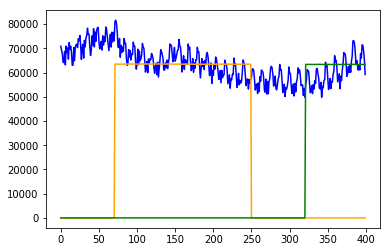

In [58]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_46))
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_46)+(look_back+look_forward-1)] = trainPredict_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot=testPredictPlot.reshape(len(ZR_46))
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(trainPredict_46)+2*(look_back+look_forward-1):len(ZR_46)-(look_back+look_forward-1)+look_back+look_forward] = testPredict_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()